# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from Policy import *

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.

#### Initialize env & parameters

In [ ]:
## INITIALISE THE ENVIRONMENT
env = Chess_Env(size_board)
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200.
from Q_values import Q_values
from SARSA import sarsa
from Double_Q import Double_Q

np.random.seed(22)

S, X, allowed_a = env.Initialise_game()
N_a = np.shape(allowed_a)[0]  # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in = np.shape(X)[0]  ## INPUT SIZE
N_h = 200  ## NUMBER OF HIDDEN NODES

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2 # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85  # THE DISCOUNT FACTOR
eta = 0.035        # THE LEARNING RATE

## INITALISE YOUR NEURAL NETWORK...
q_value = Q_values([N_in, N_h, N_a])
q_value.nn.momentum = 0.7
q_value.gamma = gamma

sarsa_v = sarsa([N_in, N_h, N_a])
sarsa_v.nn.momentum = 0.7
sarsa_v.gamma = gamma

double_q_v = Double_Q([N_in, N_h, N_a])
double_q_v.Q_primary.nn.momentum = 0.7
double_q_v.gamma = gamma
double_q_v.update_coefficient = 0.1
N_episodes = 100000  # THE NUMBER OF GAMES TO BE PLAYED

In [5]:
def agent_action(value_function_model, X, allowed_a):
    (V, _) = value_function_model(X)
    allow_v = np.copy(V)
    allow_v[np.where(allowed_a.flatten() != 1)] = 0
    if (np.max(allow_v) == 0):
        return np.random.permutation(np.where(allowed_a.flatten() == 1)[0])[0]
    else:
        return np.argmax(allow_v)

def play_one_game(value_function):
    S, X, allowed_a = env.Initialise_game()  # INITIALISE GAME
    Done = 0  # SET Done=0 AT THE BEGINNING
    i = 1  # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    while Done == 0:
        a_agent = agent_action(value_function, X, allowed_a)
        S, X, allowed_a, R, Done = env.OneStep(a_agent)
        if Done:
            return (R, i)
        if i > 16:
            return (R, i)
        i = i + 1


def period_validate(function_model, validate_games):
    # SAVING VARIABLES
    R_save_temp = np.zeros([validate_games, 1])
    N_moves_save_temp = np.zeros([validate_games, 1])
    for n in range(validate_games):
        (R, n_moves) = play_one_game(function_model)
        R_save_temp[n] = np.copy(R)
        N_moves_save_temp[n] = np.copy(n_moves)
    return (np.mean(R_save_temp), np.mean(N_moves_save_temp))


def EMA(x, y):
    k = 2 / len(x)
    ema_seq = []
    ema_prev = 0
    for t in range(0, len(x)):
        y_t = y[t] * k + ema_prev * (1 - k)
        ema_prev = y_t
        ema_seq.append(y_t)
    return (x, ema_seq)

import pickle
def save_model():
    with open("saved_model.pkl", 'wb') as output:
        pickle.dump(sarsa_v, output, pickle.HIGHEST_PROTOCOL)
        pickle.dump(q_value, output, pickle.HIGHEST_PROTOCOL)
        pickle.dump(double_q_v, output, pickle.HIGHEST_PROTOCOL)
def load_model():
    with open('saved_model.pkl', 'rb') as input:
        loaded_sarsa_v = pickle.load(input)
        loaded_q_value = pickle.load(input)
        loaded_double_q_v = pickle.load(input)
        return (loaded_sarsa_v, loaded_q_value, loaded_double_q_v)

In [6]:
def train(N_episodes, epsilon_0, model_value_function, model_training_function, model_calculate_next_R,
          model_validation_value_function):
    # global sarsa_v
    # TRAINING LOOP BONE STRUCTURE
    R_period_seq = []
    N_period_step_seq = []
    x_period_axis = []

    R_training_seq = []
    N_training_seq = []
    x_training_seq = []

    best_model = (0,None)
    for n in range(N_episodes):
        epsilon_f = epsilon_0 / (1 + beta * n)  ## DECAYING EPSILON
        sarsa_v.epsilon = epsilon_f

        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        S, X, allowed_a = env.Initialise_game()

        while Done == 0:  ## START THE EPISODE
            (value_s, neuron_value) = model_value_function(X)
            a_agent = epsilon_greedy(value_s, np.asarray(allowed_a), epsilon_f)

            S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

            if Done == 1:
                model_training_function(eta, neuron_value, a_agent, R, value_s)
                break
            else:
                ## for Double Q, use primary online value function to do argmax
                (V_next, _) = model_value_function(X_next)
                future_R = model_calculate_next_R(V_next, allowed_a_next, X_next)
                model_training_function(eta, neuron_value, a_agent, future_R, value_s, )

            # NEXT STATE AND CO. BECOME ACTUAL STATE...
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)

        ## record epic
        (R, n_moves) = play_one_game(model_validation_value_function)
        x_training_seq.append(n)
        R_training_seq.append(R)
        N_training_seq.append(n_moves)
        # (_, ema_seq) = EMA(x_training_seq, R_training_seq)
        # if( len(ema_seq) > 1):
        #     ema_q = ema_seq[-1]
        #     if (ema_q>0.999):
        #         return [(x_period_axis, R_period_seq, N_period_step_seq),
        #                 (x_training_seq, R_training_seq, N_training_seq)]

        ## temp validate
        if (n % 1000 == 0):
            (avg_R, avg_n) = period_validate(model_validation_value_function, 200)
            print(f"\r Training process {np.round(n / N_episodes * 100, 2)}%  "
                  f"avg_R: {np.round(avg_R, 2)}, avg_steps:{np.round(avg_n, 2)}", end="", flush=True)
            x_period_axis.append(n)
            R_period_seq.append(avg_R)
            N_period_step_seq.append(avg_n)

            if (avg_R > 0.99):
                return [(x_period_axis, R_period_seq, N_period_step_seq),
                        (x_training_seq, R_training_seq, N_training_seq)]

    return [(x_period_axis, R_period_seq, N_period_step_seq),
            (x_training_seq, R_training_seq, N_training_seq)]

#### Q Learning Training

In [7]:
Q_traing_his = train(N_episodes, epsilon_0,
                     lambda X: q_value.q_values(X),
                     lambda eta, neuron_value, a_agent, R, qv_s: q_value.update_q_func(eta, neuron_value, a_agent, R, qv_s),
                     lambda V_next, allowed_next,X_next: q_value.calculate_next_Q(V_next, allowed_a, X_next),
                     lambda X: q_value.q_values(X)
                     )
(Q_x_axis, Q_R_seq, Q_N_step_seq) = Q_traing_his[0]
(Q_x_training_seq, Q_R_training_seq, Q_N_training_seq) = Q_traing_his[1]
print()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


 Training process 12.0%  avg_R: 1.0, avg_steps:2.284


#### SARSA Training

In [8]:
Sarsa_his = train(N_episodes, epsilon_0,
                  lambda X: sarsa_v.sarsa_value(X),
                  lambda eta, neuron_value, a_agent, R, qv_s: sarsa_v.update_sarsa_func(eta, neuron_value, a_agent, R,
                                                                                        qv_s),
                  lambda V_next, allowed_next, X_next: sarsa_v.calculate_next_V(V_next, allowed_a, X_next),
                  lambda X: sarsa_v.sarsa_value(X)
                  )
(Sarsa_x_axis, Sarsa_R_seq, Sarsa_N_step_seq) = Sarsa_his[0]
(Sarsa_x_training_seq, Sarsa_R_training_seq, Sarsa_N_training_seq) = Sarsa_his[1]
print()

 Training process 13.0%  avg_R: 1.0, avg_steps:2.746


#### Double-Q Training

In [26]:
double_q_his = train(N_episodes, epsilon_0,
                     lambda X: double_q_v.q_primary_value(X),
                     lambda eta, neuron_value, a_agent, R, qv_s: double_q_v.update_func(eta, neuron_value, a_agent, R,
                                                                                        qv_s),
                     lambda V_next, allowed_next, X_next: double_q_v.next_action_Q(V_next, allowed_a, X_next),
                     lambda X: double_q_v.q_primary_value(X)
                     )
(dq_x_axis, dq_R_seq, dq_N_step_seq) = double_q_his[0]
(dq_x_training_seq, dq_R_training_seq, dq_N_training_seq) = double_q_his[1]
print()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


 Training process 9.0%  avg_R: 1.0, avg_steps:2.86


#### Test Model

In [ ]:
import sys, importlib
importlib.reload(sys.modules['Chess_env'])
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES
def test(agent, agent_tag):
    N_episodes = 10000
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    for n in range(N_episodes):
        (R, i) = play_one_game(agent)
        R_save[n] = np.copy(R)
        N_moves_save[n] = np.copy(i)
    print(f'Agent {agent_tag}, Average reward:', np.mean(R_save), 'Number of steps: ', np.mean(N_moves_save))

#random
# test(lambda X_in: (np.random.random(32), [] ), "Random Agent")
# test(lambda X_in: q_value.q_values(X_in), "Q_agent")
# test(lambda X_in: sarsa_v.sarsa_value(X_in), "Sarsa_agent")
# test(lambda X_in: double_q_v.q_primary_value(X_in), "Double Q")

# save_model()

#### Best Model performance

In [25]:
## load saved model
(loaded_sarsa_v, loaded_q_value, loaded_double_q_v) = load_model()
test(lambda X_in: q_value.q_values(X_in), "Q_agent")
test(lambda X_in: sarsa_v.sarsa_value(X_in), "Sarsa_agent")
test(lambda X_in: double_q_v.q_primary_value(X_in), "Double Q")

Agent Q_agent, Average reward: 0.9966 Number of steps:  2.2923
Agent Sarsa_agent, Average reward: 0.9983 Number of steps:  2.5991
Agent Double Q, Average reward: 0.9943 Number of steps:  2.8991


#### save training process data

In [ ]:
## save training process data
def assemble_data(label, x, avg_R, avg_N, x_training_seq, R_training_seq, N_training_seq):
    f_x=f"{label}_x_axis={str(x)}"
    f_avg_R = f"{label}_avg_R={str(avg_R)}"
    f_avg_N = f"{label}_avg_N={str(avg_N)}"
    f_x_training_seq = f"{label}_x_training_seq={str(x_training_seq)}"
    f_R_training_seq = f"{label}_R_training_seq={str(R_training_seq)}"
    f_N_training_seq = f"{label}_N_training_seq={str(N_training_seq)}"
    return [f_x, f_avg_R, f_avg_N, f_x_training_seq, f_R_training_seq, f_N_training_seq]

f = open("data.py", "a")
output = []
Q_data = assemble_data("Q_Learning", Q_x_axis, Q_R_seq, Q_N_step_seq,
                       Q_x_training_seq, Q_R_training_seq, Q_N_training_seq )
SARSA_data = assemble_data("SARSA", Sarsa_x_axis, Sarsa_R_seq, Sarsa_N_step_seq,
                           Sarsa_x_training_seq, Sarsa_R_training_seq, Sarsa_N_training_seq)
Dq_data = assemble_data("Double_Q", dq_x_axis, dq_R_seq, dq_N_step_seq,
                        dq_x_training_seq, dq_R_training_seq, dq_N_training_seq)
output.extend(Q_data)
output.extend(SARSA_data)
output.extend(Dq_data)
for s in output:
    # f.write(s+"\n")
    pass
f.close()

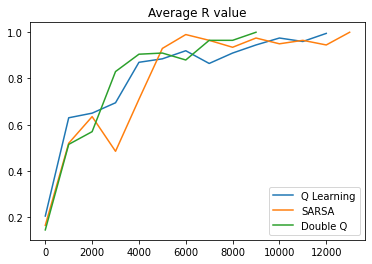

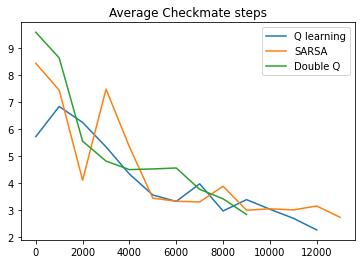

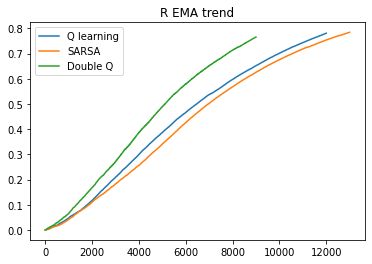

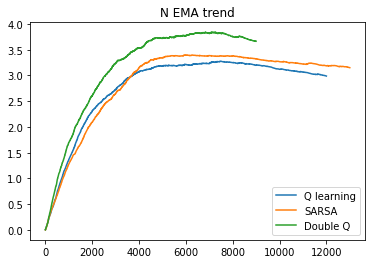

In [27]:
import sys, importlib
from best_model_data import *
importlib.reload(sys.modules['data'])

plt.figure(1)
plt.title("Average R value")
plt.plot(Q_Learning_x_axis, Q_Learning_avg_R, label="Q Learning")
plt.plot(SARSA_x_axis, SARSA_avg_R, label="SARSA")
plt.plot(Double_Q_x_axis, Double_Q_avg_R, label="Double Q")
plt.legend()

plt.figure(2)
plt.title("Average Checkmate steps")
plt.plot(Q_Learning_x_axis, Q_Learning_avg_N, label="Q learning")
plt.plot(SARSA_x_axis, SARSA_avg_N, label="SARSA")
plt.plot(Double_Q_x_axis, Double_Q_avg_N, label="Double Q")
plt.legend()

k = (len(SARSA_x_training_seq))
(Sarsa_ema_x, Sarsa_R_ema) = EMA(SARSA_x_training_seq, SARSA_R_training_seq)
(Q_ema_x, Q_R_ema) = EMA(Q_Learning_x_training_seq, Q_Learning_R_training_seq)
(Dq_ema_x, Dq_R_ema) = EMA(Double_Q_x_training_seq, Double_Q_R_training_seq)
(_, Sarsa_N_ema) = EMA(SARSA_x_training_seq, SARSA_N_training_seq)
(_, Q_N_ema) = EMA(Q_Learning_x_training_seq, Q_Learning_N_training_seq)
(_, Dq_N_ema) = EMA(Double_Q_x_training_seq, Double_Q_N_training_seq)

plt.figure(3)
plt.title("R EMA trend")
plt.plot(Q_ema_x, Q_R_ema, label="Q learning")
plt.plot(Sarsa_ema_x, Sarsa_R_ema, label="SARSA")
plt.plot(Dq_ema_x, Dq_R_ema, label="Double Q")
plt.legend()

plt.figure(4)
plt.title("N EMA trend")
plt.plot(Q_ema_x, Q_N_ema, label="Q learning")
plt.plot(Sarsa_ema_x, Sarsa_N_ema, label="SARSA")
plt.plot(Dq_ema_x, Dq_N_ema , label="Double Q")
plt.legend()